# Analysis of phospho-histone3 staining data.

In [1]:
from cellpose import models
from cellpose.io import imread
from skimage import io as skio
from skimage import measure, transform, morphology, filters
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from parse import parse
import colorcet as cc
import os
import sys
from scipy import ndimage
from pathlib import Path
from sklearn.neighbors import NearestNeighbors
from aicsimageio import AICSImage
import aicsimageio
import xml.etree.ElementTree as ET
import seaborn as sns
import pickle
plt.style.use("E:/Documents/Cohen Lab/bio_publications.mplstyle")

In [2]:
rootdir = Path("E:/Documents/Cohen Lab/Papers/Kalki_CellCycle/20240120_emi_pH3")
all_timepoint_data = {}

In [4]:
def write_imagej_file(img, filepath, dx=1, dz=1):
    with open("E:/Documents/Cohen Lab/Code/imagej_metadata_template.pkl", "rb") as f:
        imagej_metadata = pickle.load(f)

    imagej_metadata['images'] = np.prod(img.shape[:3])
    imagej_metadata['spacing'] = dz
    imagej_metadata['min'] = np.min(img[0,:,1,:,:])
    imagej_metadata['max'] = np.max(img[0,:,1,:,:])
    imagej_metadata['Ranges'] = (np.min(img[:,:,0,:,:]), np.max(img[:,:,0,:,:]), np.min(img[:,:,1,:,:]), np.max(img[:,:,1,:,:]))
    page_labels = []
    for i in range(img.shape[1]):
        for j in range(img.shape[2]):
            page_labels.append(f"c:{j+1}/{img.shape[2]}, z:{i+1}/{img.shape[1]} - Series0")
    imagej_metadata['Labels'] = page_labels
    imagej_metadata['Info'] = f"BitsPerPixel = 16\n DimensionOrder = XYCZT\n IsInterleaved = false\n IsRGB = false\n LittleEndian = true\n PixelType = uint16\n Series 0 Name = null\n SizeC = {img.shape[2]}\n SizeT = {img.shape[0]}\n SizeX = {img.shape[4]}\n SizeY = {img.shape[3]}\n SizeZ = {img.shape[1]}\n \Location = {filepath}"
    tif.imwrite(filepath, img, imagej=True, metadata=imagej_metadata, resolution=[1/dx, 1/dx])


## Nuclear segmentation using Cellpose

In [5]:
import time
timepoints = ["6hpf", "8hpf", "10hpf", "14hpf", "24hpf"]
cell_sizes_wt = [28,21,20,17,13]
cell_sizes_emi = [28,23,23,23,23]

flow_thresholds = [0.2, 0.2, 0.2, 0.1, 0.1]
target_dx = np.array([0.414, 0.414, 0.414, 0.414, 0.414])
model = models.CellposeModel(gpu=True, model_type="cyto2")

In [ ]:
for idx in range(4, -1, -1):
    timepoint = timepoints[idx]
    combined_props = pd.DataFrame()
    subfolder = rootdir / timepoint
    os.makedirs(rootdir/"analysis"/timepoint/"masks", exist_ok=True)
    czi_files = list(subfolder.glob("*.czi"))
    parse_format = "{genotype}_{timepoint}_E{embryo:d}_{tissue}-{num:2d}.czi"
    for czi_file in czi_files:
        start_time = time.time()

        file_info = parse(parse_format, czi_file.name)
        czi = AICSImage(czi_file)
        x = czi.metadata.find("Metadata")
        # Find the element "Scaling" recursively in the children of x
        scaling = x.find(".//Scaling")
        # Find the element "Distance" with attribute "Id" equal to "X"
        dx = float(scaling.find(".//Distance[@Id='X']").find("Value").text)*1e6
        dz = float(scaling.find(".//Distance[@Id='Z']").find("Value").text)*1e6
        print(f"dx: {dx}, dz: {dz}")
        print("Channels:", czi.channel_names)
        # Find element of czi.channel_names that contains "AF633"
        nuc_channel = [i for i, s in enumerate(czi.channel_names) if "AF633" in s][0]
        pH3_channel = [i for i, s in enumerate(czi.channel_names) if "AF488" in s][0]
        print(nuc_channel, pH3_channel)
        img = czi.get_image_data("ZYXC", C=[nuc_channel,pH3_channel])

        img = ndimage.median_filter(img, footprint=np.ones((1,3,3,1)))
        downsample_factor = np.round(dx/target_dx[idx], decimals=2)
        print(f"Downsampling by {downsample_factor}x")
        print(img.shape)
        if downsample_factor != 1:
            img=transform.rescale(img, (1, downsample_factor, downsample_factor, 1), anti_aliasing=True, preserve_range=True, order=1)
        print(img.shape)

        # Run cellpose
        if file_info["genotype"] == "WT":
            cell_size = cell_sizes_wt[idx]
        elif file_info["genotype"] == "emi1":
            cell_size = cell_sizes_emi[idx]
        masks, flows, styles, diams = model.eval(img[:,:,:,0], diameter=cell_size, channels=[0,0], 
                                                    do_3D=True, anisotropy=dz/(target_dx[idx]), min_size=600, flow_threshold=0.2)
        
        # Save masks overlayed onto image
        filepath = str(rootdir/"analysis"/timepoint/"masks"/f"{file_info['genotype']}_{file_info['timepoint']}_E{file_info['embryo']}_{file_info['tissue']}_mask.tif")
        mask_overlay = np.zeros((1,masks.shape[0],2,masks.shape[1], masks.shape[2]), dtype=np.uint16)
        mask_overlay[0,:,0,:,:] = img[:,:,:,0]
        mask_overlay[0,:,1,:,:] = masks
        write_imagej_file(mask_overlay, filepath, dx=target_dx[idx], dz=dz)
        
        # Measure properties of the masks
        props = measure.regionprops_table(masks, intensity_image=img[:,:,:,1], properties=["label", "area", "centroid", "intensity_mean"])
        props = pd.DataFrame(props)
        props["timepoint"] = timepoint
        props["embryo"] = file_info["embryo"]
        props["genotype"] = file_info["genotype"]
        props["tissue"] = file_info["tissue"]
        props["volume_um3"] = props["area"] * dz*(target_dx[idx])**2
        
        # Generate a proposed cutoff intensity for the pH3 channel using Otsu thresholding of the max projection
        intensity_maxproj = np.max(img[:,:,:,1], axis=0)
        otsu_cutoff = filters.threshold_otsu(intensity_maxproj)
        skio.imsave(rootdir/"analysis"/timepoint/"masks"/f"{file_info['genotype']}_{file_info['timepoint']}_E{file_info['embryo']}_{file_info['tissue']}_maxproj.tif", intensity_maxproj)
        props["proposed_cutoff"] = otsu_cutoff
        
        # Collect and save results
        props.to_csv(rootdir/"analysis"/timepoint/f"{file_info['genotype']}_{file_info['timepoint']}_E{file_info['embryo']}_{file_info['tissue']}_props.csv", index=False)
        combined_props = pd.concat([combined_props, props], axis=0)
        combined_props.to_csv(rootdir/"analysis"/timepoint/f"combined_props_{timepoint}.csv", index=False)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print("Voxel size: ", dz*(target_dx[idx])**2)
        print(f"Finished {file_info['genotype']}_{file_info['timepoint']}_E{file_info['embryo']}_{file_info['tissue']} in {elapsed_time} seconds")
    all_timepoint_data[timepoint] = combined_props


### Clean up segmentation data

In [64]:
# group all timepoints
all_timepoint_data = pd.concat(all_timepoint_data.values(), axis=0)
all_timepoint_data["hpf"] = all_timepoint_data["timepoint"].apply(lambda x: int(x[:-3]))
all_timepoint_data.to_csv(rootdir/"analysis"/"all_timepoints_combined.csv", index=False)

In [4]:
all_timepoint_data = pd.read_csv(rootdir/"analysis"/"all_timepoints_combined.csv")
all_timepoint_data["genotype"] = all_timepoint_data["genotype"].map({"emi1": "hi2648", "WT": "Control"})

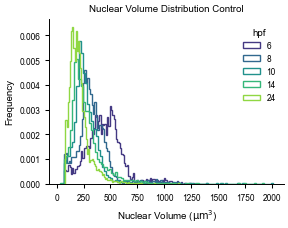

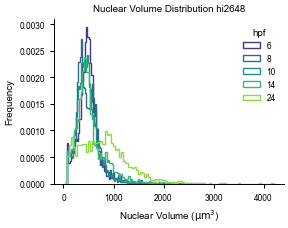

In [5]:
colormap = sns.color_palette("viridis", n_colors = 5)
for genotype, data in all_timepoint_data.groupby("genotype"):
    fig, ax = plt.subplots(figsize=(3,2.4))
    for idx, (name, group) in enumerate(data.groupby("hpf")):        
        ax.hist(group["volume_um3"], bins=100, label=name, alpha=1, density=True, color=colormap[idx], histtype="step")
    ax.set_xlabel(r"Nuclear Volume ($\mathrm{\mu m^3}$)")
    ax.set_ylabel("Frequency")
    ax.legend(title="hpf")
    ax.set_title(f"Nuclear Volume Distribution {genotype}")
    plt.tight_layout()
    plt.savefig(rootdir/"analysis"/f"nuclear_volume_distribution_{genotype}.svg")


In [6]:
nuc_size_cutoff = 80
df_filtered = pd.DataFrame(all_timepoint_data.loc[all_timepoint_data["volume_um3"] > nuc_size_cutoff,:])
df_filtered.loc[:, "sample"] = df_filtered.apply(lambda x: f"{x['genotype']}_{x['timepoint']}_E{x['embryo']}_{x['tissue']}", axis=1)
df_filtered.to_csv(rootdir/"analysis"/"filtered_props.csv", index=False)

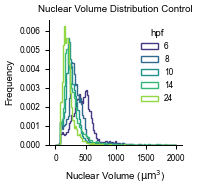

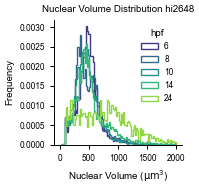

In [8]:
colormap = sns.color_palette("viridis", n_colors = 5)
for genotype, data in df_filtered.groupby("genotype"):
    fig, ax = plt.subplots(figsize=(2,2))
    for idx, (name, group) in enumerate(data.groupby("hpf")):        
        ax.hist(group["volume_um3"], bins=np.linspace(0, 2000, 100), label=name, alpha=1, density=True, color=colormap[idx], histtype="step")
    ax.set_xlabel(r"Nuclear Volume ($\mathrm{\mu m^3}$)")
    ax.set_ylabel("Frequency")
    ax.legend(title="hpf")
    ax.set_title(f"Nuclear Volume Distribution {genotype}")
    plt.tight_layout()
    plt.savefig(rootdir/"analysis"/f"nuclear_volume_distribution_filtered_{genotype}.svg")

In [9]:
# Plot median nuclear volume per sample grouped by genotype and timepoint
median_nuclear_volume = df_filtered.groupby(["sample"]).agg({"volume_um3": "median", "genotype": "first", "hpf": "first", "timepoint": "first"}).reset_index()
fig1, ax1 = plt.subplots(figsize=(3,2))
x_order = ["6hpf", "8hpf", "10hpf", "14hpf", "24hpf"]
sns.swarmplot(data=median_nuclear_volume, x="timepoint", y="volume_um3", hue="genotype", order=x_order, dodge=True, ax=ax1, size=2.5, palette=["#A9A9A9", "#00CDCD"])
ax1.set_xlabel("Timepoint")
ax1.set_ylabel(r"Median nuclear volume ($\mathrm{\mu m^3}$)")
plt.savefig(rootdir/"analysis"/"median_nuclear_volume_over_time.svg")

In [11]:
per_sample_cutoffs = df_filtered.groupby(["genotype", "timepoint", "sample"])["proposed_cutoff"].first().reset_index()
for name, group in per_sample_cutoffs.groupby(["genotype", "timepoint"]):
    print(name, group["proposed_cutoff"].mean(), group["proposed_cutoff"].std())

('Control', '10hpf') 114.05278490735441 11.269396410380898
('Control', '14hpf') 117.70520909530671 3.313694052939972
('Control', '24hpf') 96.82453952381474 7.106593194826233
('Control', '6hpf') 111.94133472022428 11.375255726784138
('Control', '8hpf') 123.68557803635268 3.8230895033177923
('hi2648', '10hpf') 98.3065392548168 31.31326988026798
('hi2648', '14hpf') 113.22265625 6.941756308878573
('hi2648', '24hpf') 55.74674494772412 21.956379750713843
('hi2648', '6hpf') 111.39646248169036 17.283546343582806
('hi2648', '8hpf') 96.3059627094771 47.258813424512525


In [12]:
cutoff_multiplier = 0.5
df_filtered["pH3"] = df_filtered["intensity_mean"] > df_filtered["proposed_cutoff"]*cutoff_multiplier
pH3_counts = df_filtered.groupby("sample").agg({"pH3": "sum", "label": "count", "genotype": "first", "timepoint": "first", "embryo": "first", "tissue": "first", "hpf": "first"})
pH3_counts["pH3_fraction"] = pH3_counts["pH3"] / pH3_counts["label"]
pH3_counts.to_csv(rootdir/"analysis"/"pH3_counts.csv")

In [15]:
pH3_fraction_median = pH3_counts.groupby(["genotype", "timepoint"]).agg({"pH3_fraction": "median", "hpf": "first"}).reset_index()
pH3_fraction_median_ratio = pH3_fraction_median.pivot(index="timepoint", columns="genotype", values="pH3_fraction")
pH3_fraction_median_ratio["ratio"] = pH3_fraction_median_ratio["hi2648"] / pH3_fraction_median_ratio["Control"]
pH3_fraction_median_ratio.reset_index(inplace=True)
pH3_fraction_median_ratio["hpf"] = pH3_fraction_median_ratio["timepoint"].apply(lambda x: int(x[:-3]))
pH3_fraction_median_ratio = pH3_fraction_median_ratio.sort_values("hpf")
pH3_fraction_median_ratio.to_csv(rootdir/"analysis"/"pH3_fraction_median_ratio.csv")

In [19]:
pH3_fraction_mean = pH3_counts.groupby(["genotype", "timepoint"]).agg({"pH3_fraction": "mean", "hpf": "first"}).reset_index()
pH3_fraction_mean_ratio = pH3_fraction_mean.pivot(index="timepoint", columns="genotype", values="pH3_fraction")
pH3_fraction_mean_ratio["ratio"] = pH3_fraction_mean_ratio["hi2648"] / pH3_fraction_mean_ratio["Control"]
pH3_fraction_mean_ratio.reset_index(inplace=True)
pH3_fraction_mean_ratio["hpf"] = pH3_fraction_mean_ratio["timepoint"].apply(lambda x: int(x[:-3]))
pH3_fraction_mean_ratio = pH3_fraction_mean_ratio.sort_values("hpf")
pH3_fraction_mean_ratio.to_csv(rootdir/"analysis"/"pH3_fraction_mean_ratio.csv")

In [16]:
pH3_counts["pH3_percentage"] = pH3_counts["pH3_fraction"]*100
pH3_fraction_median_ratio["pH3_percentage"] = pH3_fraction_median_ratio["ratio"]*100

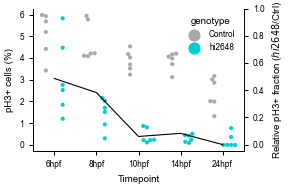

In [18]:
fig1, ax1 = plt.subplots(figsize=(3,2))
x_order = ["6hpf", "8hpf", "10hpf", "14hpf", "24hpf"]
sns.swarmplot(data=pH3_counts, x="timepoint", y="pH3_percentage", hue="genotype", order=x_order, dodge=True, ax=ax1, size=3, palette=["#A9A9A9", "#00CDCD"])
ax2 = ax1.twinx()
sns.lineplot(data=pH3_fraction_median_ratio, x="timepoint", y="ratio", ax=ax2, color="black")
ax2.set_ylabel(r"Relative pH3+ fraction ($\it{hi2648}$/Ctrl)")
ax2.set_ylim(-0.05, 1)
ax1.set_xlabel("Timepoint")
ax1.set_ylabel("pH3+ cells (%)")
# Show right y-axis spine
ax2.spines['right'].set_visible(True)
plt.tight_layout()
plt.savefig(rootdir/"analysis"/"pH3_fraction_over_time.svg")